# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *


In [3]:
import mlflow
from azureml.core import Workspace

In [4]:
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [5]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'co_Day1DangerAboveTreeline_small'
#file_label = 'day1above'
#label = 'Day1DangerAboveTreeline'

In [8]:
mlflow.set_experiment(file_label)

In [9]:
mlflow.log_param('TrainSamples', 5000)

In [63]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [64]:
utils = TSAIUtilities(X, label)

In [65]:
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'

In [66]:
feature_means = utils.get_feature_means(means_fn)

In [67]:
feature_std = utils.get_feature_std(std_fn)

In [68]:
feature_means[:10]

array([8.46383991e-05, 1.23039310e-04, 4.68801118e-05, 9.72591733e-05,
       1.12348433e-04, 8.25398456e-05, 9.74916184e-05, 1.06246014e-04,
       8.91125965e-05, 1.02773825e-04], dtype=float32)

In [69]:
feature_std[:10]

array([4.1988005e-05, 5.3214484e-05, 5.1398263e-05, 1.8762872e-05,
       2.1872047e-05, 1.9973615e-05, 2.1034301e-05, 2.1900385e-05,
       2.2395125e-05, 2.8698640e-05], dtype=float32)

In [70]:
X = X[:,:,:]

In [17]:
mlflow.log_param('Lookback', 30)

In [71]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
i = 0
y_train_df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet')  

y_test_df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet')  
y_df = pd.concat([y_train_df, y_test_df]).reset_index(drop=True)

In [15]:
y_df.shape

(6000, 302)

In [72]:
no_dupes = y_df.drop_duplicates()

In [73]:
no_dupes.shape

(6000, 302)

In [74]:
y_df['season'].value_counts()

17-18    1746
15-16    1635
16-17    1619
18-19    1000
Name: season, dtype: int64

In [19]:
y_df['parsed_date'].value_counts()

2017-01-10    99
2017-01-05    99
2016-02-02    93
2016-02-01    90
2016-12-17    83
              ..
2018-12-10     1
2017-03-10     1
2015-11-15     1
2019-03-22     1
2016-11-20     1
Name: parsed_date, Length: 618, dtype: int64

In [20]:
y_df[label].value_counts()

Considerable    1500
High            1500
Low             1500
Moderate        1500
Name: Day1DangerAboveTreeline, dtype: int64

In [75]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [76]:
y.shape

(6000,)

In [77]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
train_test_split = 5000
num_y = 1000
#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_y)]).shuffle())

In [78]:
splits_2

((#5000) [3173,3197,1509,2583,3273,4831,3213,1973,103,2495...],
 (#1000) [5205,5500,5770,5820,5258,5672,5450,5323,5229,5581...])

In [79]:
#load and check the means and std deviations
feature_means = (np.nan_to_num(feature_means))

In [80]:
np.isnan(feature_means).any()

False

In [81]:
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [82]:
np.isnan(feature_std).any()

False

In [83]:
X.shape

(6000, 978, 180)

In [90]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [62]:
X[0]

array([[          nan,           nan,           nan, ..., 2.1210001e+02,
        2.1039999e+02, 2.1050000e+02],
       [          nan,           nan,           nan, ..., 2.1460001e+02,
        2.1310001e+02, 2.1260001e+02],
       [          nan,           nan,           nan, ..., 2.1365715e+02,
        2.1235715e+02, 2.1204286e+02],
       ...,
       [          nan,           nan,           nan, ..., 1.0900000e+00,
        6.9999999e-01, 6.3999999e-01],
       [          nan,           nan,           nan, ..., 2.5000000e+00,
        3.0999999e+00, 2.5000000e+00],
       [          nan,           nan,           nan, ..., 8.6720007e-07,
        7.1199997e-07, 8.8010006e-07]], dtype=float32)

<AxesSubplot:title={'center':'2'}>

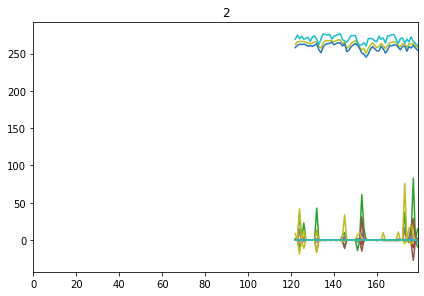

In [91]:
#check on set
show_at(dsets.valid, 0)

In [92]:
class TSStandardizeNanMeanReplaceNan(Transform):
    #method to standardize each batch while also replacing any nans with the mean value before standarization
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, feature_means=None, std=None, feature_std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.feature_means = feature_means
        self.feature_std = feature_std
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
        
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [93]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan(feature_means=feature_means, feature_std=feature_std)], num_workers=0)

In [94]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

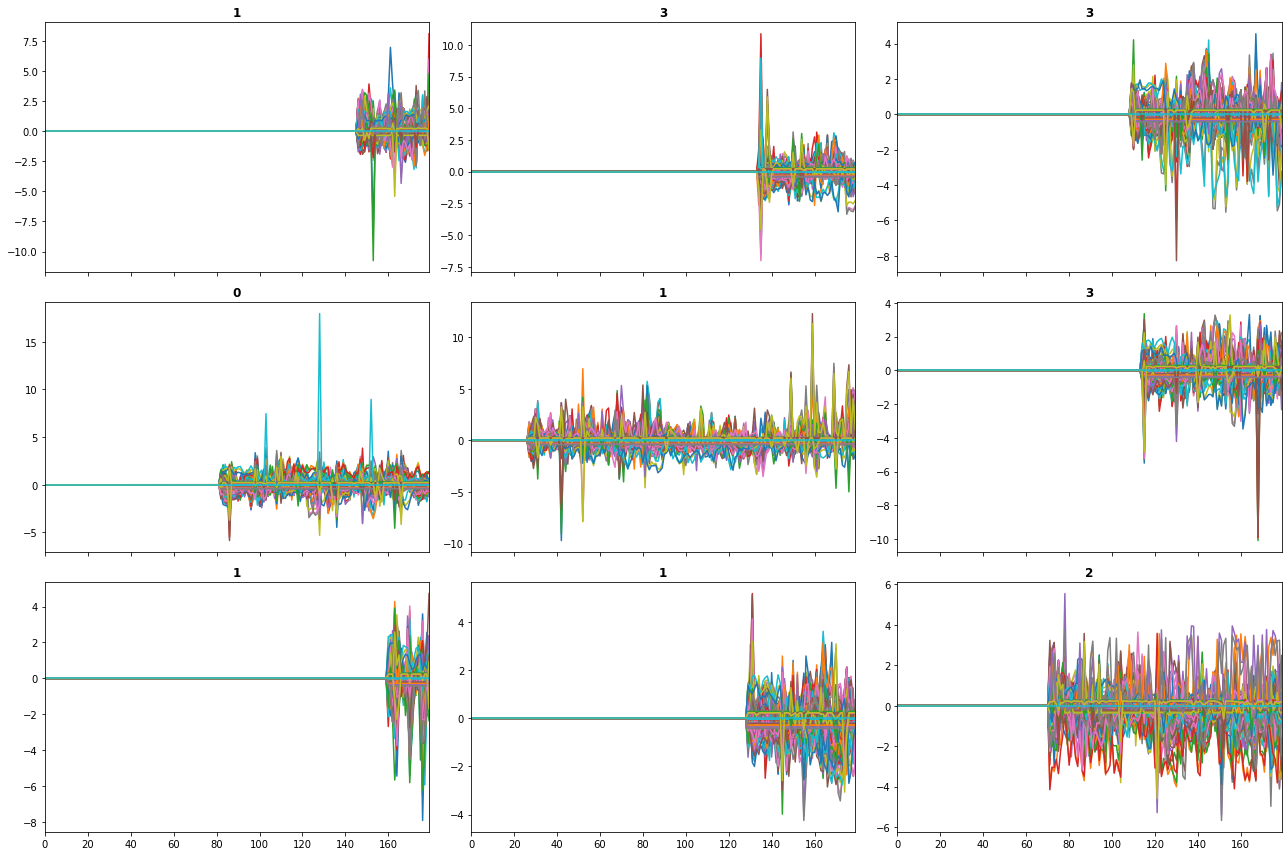

In [95]:
dls.show_batch()

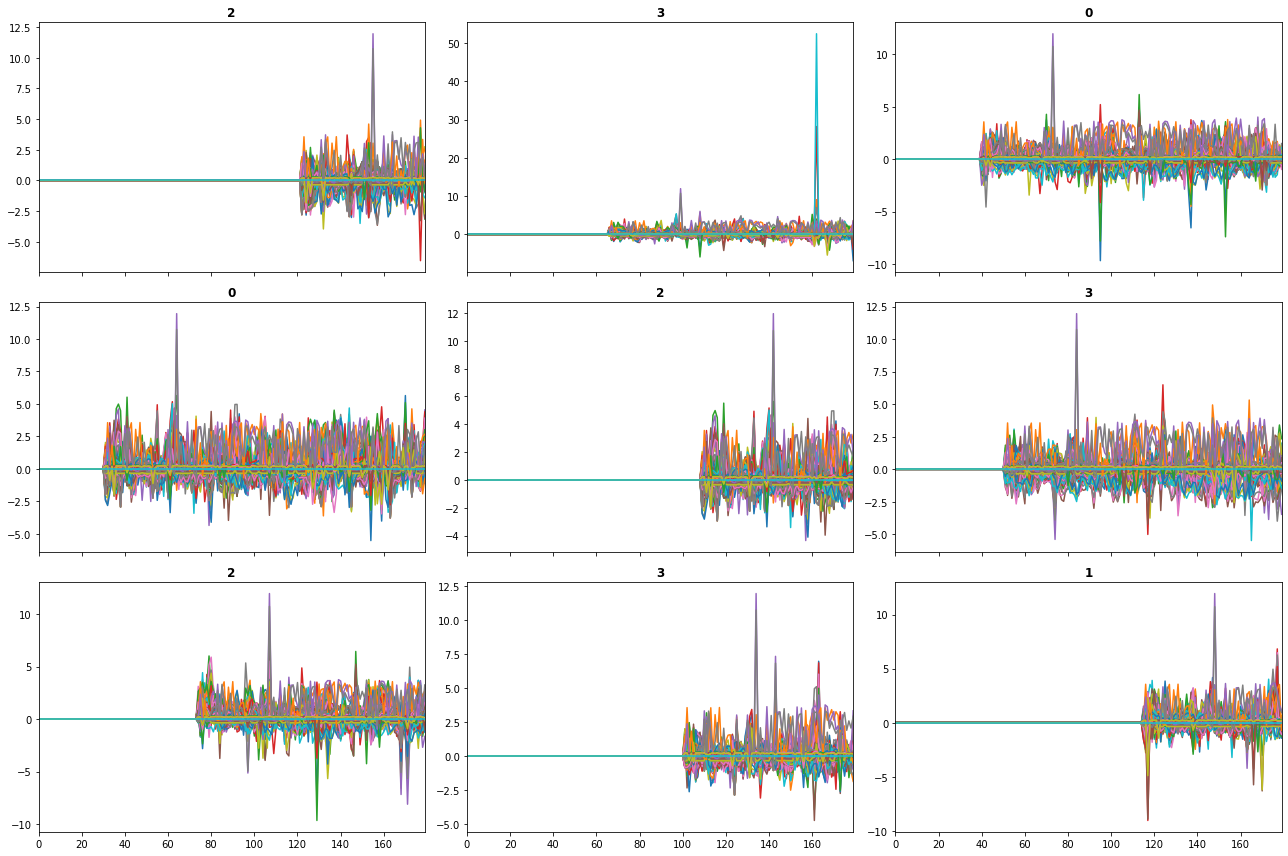

In [96]:
dls.valid.show_batch()

In [97]:
dls.c

4

In [98]:
dls.vars

100

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [110]:
model = LSTM(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.8)
learn = Learner(dls, model, metrics=accuracy)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

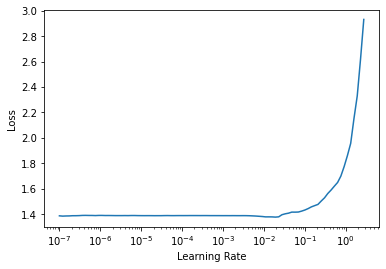

In [72]:
learn.lr_find()

In [45]:
mlflow.log_param('lr', 1e-2)

In [111]:
#without oversampling
learn.fit_one_cycle(7, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.305192,1.460838,0.347000,00:09
1,1.220409,1.535293,0.319000,00:09
2,1.197311,1.496448,0.356000,00:09
3,1.129619,1.366930,0.407000,00:09
4,1.076879,1.507126,0.381000,00:09
5,1.005870,1.516771,0.361000,00:09
6,0.962556,1.525974,0.349000,00:09


In [47]:
mlflow.log_param('Model', str(type(model)))

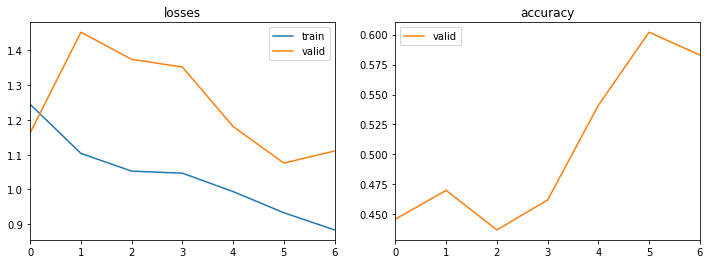

In [89]:
learn.recorder.plot_metrics()

### Results


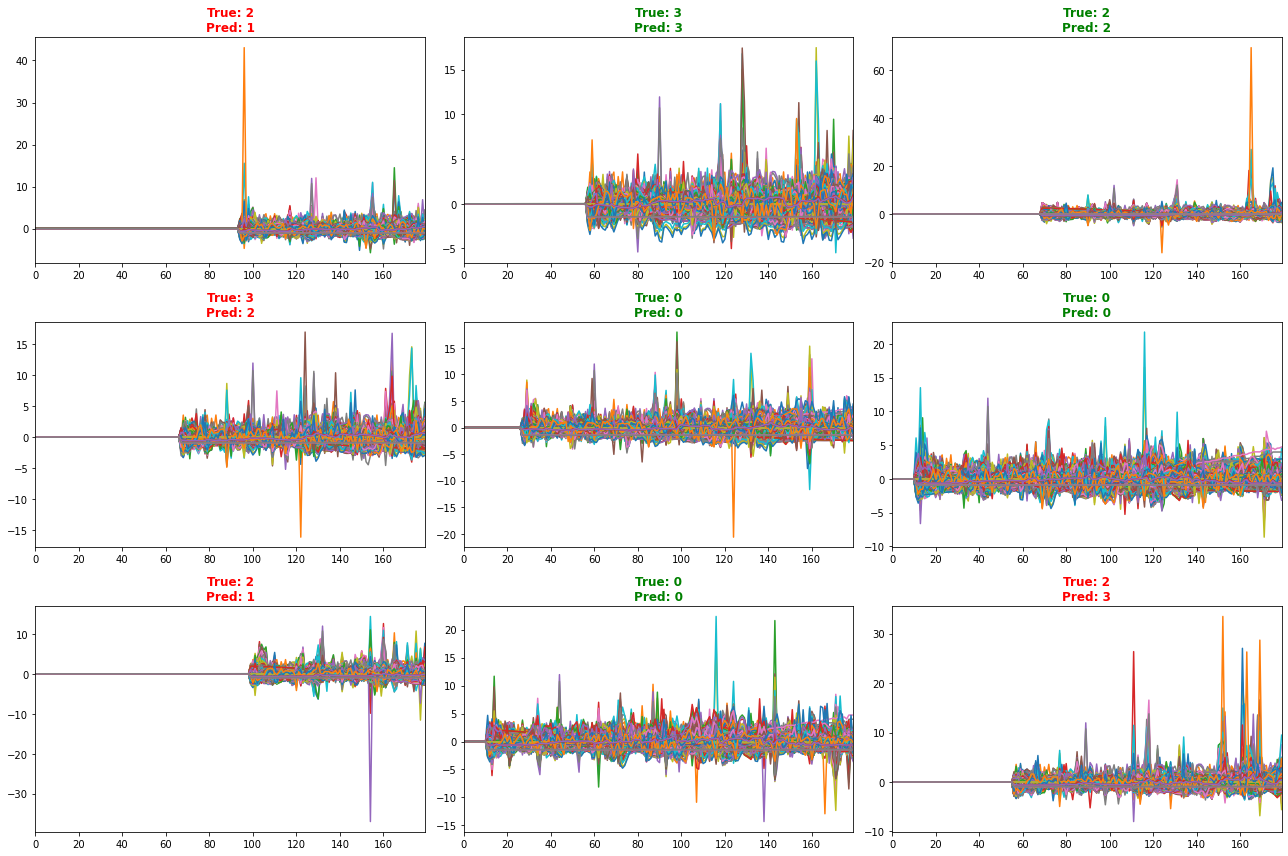

In [35]:
learn.show_results()

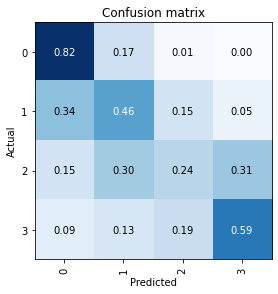

In [36]:
#d,t = flatten_check(interp.decoded, interp.targs)
#print(str(skm.accuracy_score(t, d)))
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

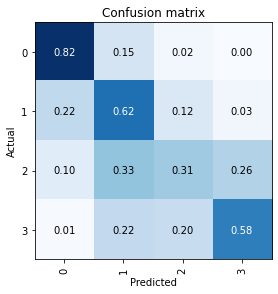

In [90]:
#100 features
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

In [173]:
mlflow.log_param('Model', str(type(m)))
mlflow.log_param('Num Hidden ', h)
mlflow.log_param('Num Layers ', l)
mlflow.log_param('RNN Dropout ',d)
mlflow.log_param('FC Dropout ', f)
mlflow.log_param('Bidirectional ',b)

In [174]:
cm = interp.confusion_matrix()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for r in range(len(cm)):
    for c in range(len(cm[r])):
        mlflow.log_metric('Actual ' + str(r) + ' Predicted ' + str(c), cm[r,c])

d,t = flatten_check(interp.decoded, interp.targs)
mlflow.log_metric('Test Accuracy', skm.accuracy_score(t, d))

In [175]:
mlflow.end_run()

In [37]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [91]:
net = learn.model.cpu()

In [92]:
b = dls.one_batch()

In [93]:
test_input_tensor = b[0].type(torch.FloatTensor)

In [94]:
test_labels = b[1].cpu().data.numpy()

In [95]:
out_probs = net(test_input_tensor).detach().cpu().numpy()
out_classes = np.argmax(out_probs, axis=1)
train_accuracy = sum(out_classes == test_labels) / len(test_labels)
print("Accuracy:", train_accuracy )

Accuracy: 0.625


In [43]:
mlflow.log_metric('Train Accuracy', train_accuracy)

NameError: name 'mlflow' is not defined

In [96]:
ig = IntegratedGradients(net)

In [97]:
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [36]:
feature_names = pd.read_csv(ml_path + '/FeatureLabels_' + file_label + '.csv')
feature_names = feature_names['0'].sort_values().values

In [37]:
feature_names = feature_names[feature_filter]

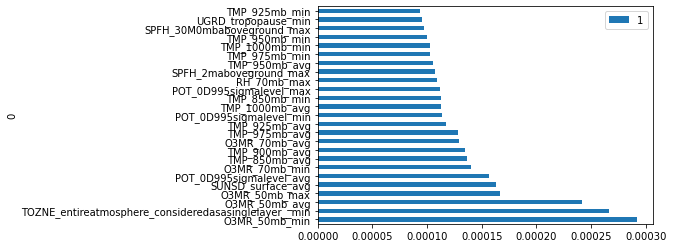

In [101]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    pd.DataFrame(zip(feature_names, np.mean(importances, axis=(0,2)))).sort_values(1, ascending=False)[:25].plot.barh(x=0, y=1)

visualize_importances(feature_names, attr)

In [50]:
top_features =  pd.DataFrame(zip(feature_names, np.mean(attr, axis=(0,2))), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [51]:
top_features.to_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [29]:
top_features = pd.read_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [85]:
orig_X = X

In [86]:
orig_feature_means = feature_means

In [87]:
orig_feature_std = feature_std

In [134]:
mlflow.end_run()

In [88]:
feature_filter = top_features[:100].index

In [89]:
X = orig_X[:, feature_filter, :]
feature_means = orig_feature_means[feature_filter]
feature_std = orig_feature_std[feature_filter]

In [35]:
fill_values = torch.zeros_like(TSTensor(X))
for i in range(0,X.shape[1]):
    fill_values[:,i,:] = torch.full_like(TSTensor(X[:,i,:]), feature_means[i])
        
X_noNan = torch.where(torch.isnan(TSTensor(X)), fill_values, TSTensor(X))

In [40]:
X_noNan[:,:,-30:].shape

torch.Size([6000, 100, 30])